In [1]:
## Proyecto NBA
### Integrantes: yo y otros dos JAJAJAJA
# Para garantizar que el proyecto de análisis de datos de la NBA se ejecute
# de manera óptima y sin conflictos con otras librerías o versiones 
# de Python que puedas tener en tu sistema, es esencial que crees un 
# entorno virtual. Un entorno virtual es un espacio aislado que te 
# permite instalar y administrar las dependencias de tu proyecto de 
# forma independiente. Y luego instalar las las librerias con pip o conda.

# pip install pymongo cassandra-driver py2neo pandas numpy matplotlib seaborn plotly ipywidgets requests
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pymongo
from pymongo import MongoClient
import json
import requests
import ipywidgets as widgets
import plotly.graph_objects as go




## Proyecto NBA
<br>
# Integrantes:
</br>

## Introducción al Proyecto de Análisis de Datos de la NBA

En la era moderna del deporte, el análisis de datos ha asumido un rol crucial, transformando la forma en que equipos, entrenadores, y aficionados entienden el juego. En el baloncesto, y específicamente en la NBA, este análisis se ha vuelto fundamental para descubrir insights que no son visibles a simple vista. Al examinar meticulosamente estadísticas y patrones de juego, los equipos pueden mejorar su estrategia, entrenamiento, y toma de decisiones en la cancha.

El proyecto que presentamos busca aprovechar el poder del análisis de datos en el contexto de la NBA. Utilizamos una combinación de bases de datos avanzadas - MongoDB, Cassandra y Neo4j - para abordar este desafío desde diferentes ángulos. Cada una de estas bases de datos ofrece características únicas que son esenciales para entender profundamente los aspectos multifacéticos del juego.

# MongoDB 
Una base de datos NoSQL, nos permite manejar grandes volúmenes de datos no estructurados. Esto es esencial para analizar estadísticas de jugadores y equipos, historiales de partidos, y otros datos en formatos variados. Su flexibilidad para manejar diferentes tipos de datos nos permite una exploración más libre y creativa, crucial en el análisis deportivo donde cada temporada trae nuevas tendencias y patrones.

# Cassandra
Por otro lado, brilla en el manejo de grandes cantidades de datos distribuidos, ofreciendo lecturas y escrituras rápidas. Esto es crucial para el análisis en tiempo real y para manejar grandes conjuntos de datos históricos, permitiéndonos identificar tendencias a lo largo del tiempo y entender mejor el rendimiento de los equipos y jugadores a lo largo de diferentes temporadas.

# Neo4j

Finalmente, Neo4j, una base de datos de grafos, nos permite analizar las complejas interacciones y relaciones dentro de los datos. En un deporte como el baloncesto, donde las relaciones entre jugadores, equipos, y entrenadores juegan un papel fundamental, Neo4j nos ayuda a visualizar y entender estas redes, revelando cómo las interacciones personales pueden influir en el rendimiento y la estrategia.

Al combinar estos enfoques y tecnologías, nuestro proyecto no solo busca responder preguntas existentes sobre estrategias de juego, rendimiento de jugadores y dinámicas de equipo, sino también descubrir nuevas preguntas y perspectivas. En última instancia, el análisis avanzado de datos de la NBA nos permite no solo entender mejor el juego tal como lo conocemos hoy, sino también anticipar y modelar el futuro del baloncesto profesional.

Aqui vamos a poner los codigo de como creamos las distintas base de datos: <br>
Nota: recuerda tener los contenedores prendidos para que los codigos funcione y tambien si corriste este codigo una vez no funcionara porque se va a reescribir los datos.

In [3]:
import requests
from pymongo import MongoClient

# Realizar la solicitud a la API
for season in range(2010, 2024):
	response = requests.get('https://nba-stats-db.herokuapp.com/api/playerdata/season/' + str(season))
	data = response.json()

	# Conectar a MongoDB
	client = MongoClient('mongodb://localhost:27017/')
	db = client['nba']
	collection = db['player_data']

	# Insertar datos en MongoDB
	collection.insert_many(data['results'])
 



In [8]:
##codigos de cassandra
from pymongo import MongoClient
from cassandra.cluster import Cluster
from cassandra.query import BatchStatement

# Conexión a MongoDB
mongo_client = MongoClient('mongodb://localhost:27017/')
mongo_db = mongo_client['nba']
mongo_collection = mongo_db['player_data']

# Conexión a Cassandra en el puerto 9042
cluster = Cluster(['localhost'], port=9042)
session = cluster.connect()

# Crear keyspace y tabla si no existen
session.execute("""
    CREATE KEYSPACE IF NOT EXISTS nba WITH replication = {
        'class': 'SimpleStrategy', 
        'replication_factor': '1'
    }
""")
session.execute("""
    CREATE TABLE IF NOT EXISTS nba.player_stats (
        id int PRIMARY KEY,
        player_name text,
        age int,
        games int,
        games_started int,
        minutes_played int,
        field_goals int,
        field_attempts int,
        field_percent text,
        three_fg int,
        three_attempts int,
        three_percent text,
        two_fg int,
        two_attempts int,
        two_percent text,
        effect_fg_percent text,
        ft int,
        fta int,
        ft_percent text,
        ORB int,
        DRB int,
        TRB int,
        AST int,
        STL int,
        BLK int,
        TOV int,
        PF int,
        PTS int,
        team text,
        season int
    )
""")

# Función para insertar datos en Cassandra
def insert_into_cassandra(data):
    prepared = session.prepare("""
        INSERT INTO nba.player_stats (id, player_name, age, games, games_started, minutes_played, field_goals, field_attempts, field_percent, three_fg, three_attempts, three_percent, two_fg, two_attempts, two_percent, effect_fg_percent, ft, fta, ft_percent, ORB, DRB, TRB, AST, STL, BLK, TOV, PF, PTS, team, season)
        VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
    """)
    session.execute(prepared, (data['id'], data['player_name'], data['age'], data['games'], data['games_started'], data['minutes_played'], data['field_goals'], data['field_attempts'], data['field_percent'], data['three_fg'], data['three_attempts'], data['three_percent'], data['two_fg'], data['two_attempts'], data['two_percent'], data['effect_fg_percent'], data['ft'], data['fta'], data['ft_percent'], data['ORB'], data['DRB'], data['TRB'], data['AST'], data['STL'], data['BLK'], data['TOV'], data['PF'], data['PTS'], data['team'], data['season']))

# Transferir datos de MongoDB a Cassandra
for data in mongo_collection.find():
    insert_into_cassandra(data)


In [ ]:
## codigo de Neo4j

Ahora, procederemos a analizar los datos de la NBA, centrándonos en desvelar patrones clave y correlaciones que influyen en el rendimiento y las estrategias dentro del baloncesto profesional.

# Usando MongoDB

1. Jugadores con Alto Porcentaje de Campo y Participación en Juegos

Problema que Soluciona: Este query identifica jugadores con un alto porcentaje de tiros de campo y una participación activa en la temporada, esencial para evaluar la consistencia y eficacia en jugadores clave.

,_id,id,player_name,age,games,games_started,minutes_played,field_goals,field_attempts,field_percent,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,team,season
0,6568a6ea1ec44788b32f9837,66,Jericho Sims,24,52,16,812,83,107,0.776,...,143,242,25,15,28,27,96,178,NYK,2023
1,6568a6e81ec44788b32f978f,1424,DeAndre Jordan,32,57,43,1246,190,249,0.763,...,310,427,93,17,65,85,116,426,BRK,2021
2,6568a6e91ec44788b32f97db,684,Mitchell Robinson,23,72,62,1848,261,343,0.761,...,322,617,38,58,133,60,195,610,NYK,2022
3,6568a6e71ec44788b32f9702,2010,Mitchell Robinson,21,61,7,1412,253,341,0.742,...,242,428,36,52,119,37,194,590,NYK,2020
4,6568a6e91ec44788b32f97c0,657,Robert Williams,24,61,61,1804,271,368,0.736,...,350,588,121,56,134,63,137,607,BOS,2022
5,6568a6e81ec44788b32f9769,1386,Robert Williams,23,52,13,985,186,258,0.721,...,225,358,94,43,91,52,105,417,BOS,2021
6,6568a6e21ec44788b32f9433,6008,Chris Wilcox,30,61,7,830,110,153,0.719,...,125,180,22,32,28,34,125,259,BOS,2013
7,6568a6ea1ec44788b32f9841,76,Nic Claxton,23,76,76,2271,414,587,0.705,...,518,702,144,65,189,96,212,961,BRK,2023
8,6568a6e71ec44788b32f96ab,2614,Mitchell Robinson,20,66,19,1360,202,291,0.694,...,246,423,37,52,161,35,217,485,NYK,2019
9,6568a6e11ec44788b32f93d4,6537,Tyson Chandler,29,62,62,2061,241,355,0.679,...,400,612,56,56,89,102,186,699,NYK,2012


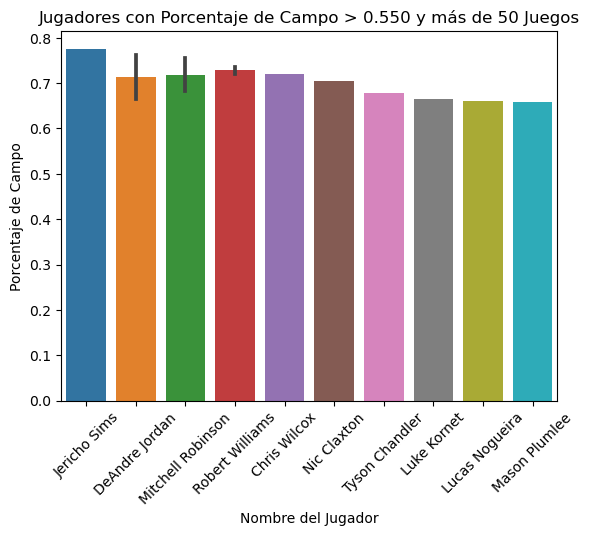

In [4]:


client = pymongo.MongoClient("mongodb://localhost:27017/")
db = client["nba"]
collection = db["player_data"]

query1 = collection.find({
    "field_percent": { "$gt": "0.550" },
    "games": { "$gt": 50 }
}).sort("field_percent", -1).limit(15)

df1 = pd.DataFrame(list(query1))
# Asegúrate de que 'field_percent' sea numérico
df1['field_percent'] = pd.to_numeric(df1['field_percent'], errors='coerce')


display(df1)
sns.barplot(data=df1, x='player_name', y='field_percent')
plt.xticks(rotation=45)
plt.title('Jugadores con Porcentaje de Campo > 0.550 y más de 50 Juegos')
plt.ylabel('Porcentaje de Campo')
plt.xlabel('Nombre del Jugador')
plt.show()




2. Top 5 Jugadores por Asistencias en una Temporada Específica

Problema que Soluciona: Este análisis destaca a los jugadores con el mayor número de asistencias en la temporada 2010, crucial para entender quiénes son los mejores facilitadores en el juego.

,_id,totalAssists
0,Rajon Rondo,794
1,Andre Iguodala,472
2,Aaron Brooks,434
3,Devin Harris,423
4,Jarrett Jack,413
5,José Calderón,404
6,Chris Duhon,378


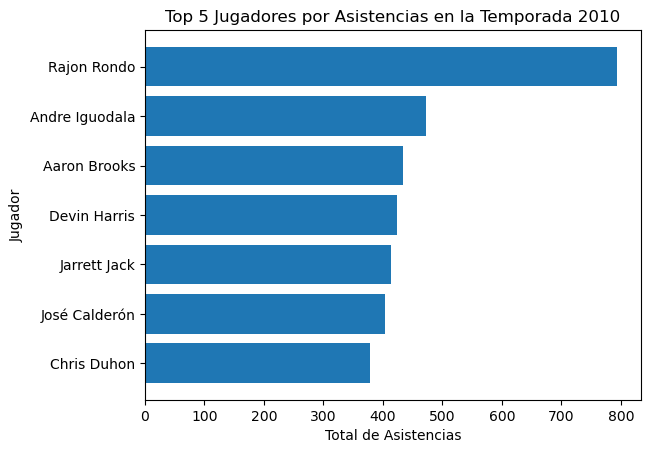

In [5]:
query2 = collection.aggregate([
    { "$match": { "season": 2010 } },
    { "$group": { "_id": "$player_name", "totalAssists": { "$sum": "$AST" } } },
    { "$sort": { "totalAssists": -1 } },
    { "$limit": 7 }
])

df2 = pd.DataFrame(list(query2))

display(df2)
df2_sorted = df2.sort_values('totalAssists', ascending=True)
plt.barh(df2_sorted['_id'], df2_sorted['totalAssists'])
plt.xlabel('Total de Asistencias')
plt.ylabel('Jugador')
plt.title('Top 5 Jugadores por Asistencias en la Temporada 2010')
plt.show()



3. Mejor Jugador en Tiros de Tres Puntos por Temporada

Problema que Soluciona: Identifica al jugador con mejor promedio en tiros de tres puntos por temporada, proporcionando insights sobre los tiradores más eficientes año tras año.

In [6]:
from IPython.display import display
query3 = collection.aggregate([
    { "$unwind": "$season" },
    { "$group": { "_id": { "player": "$player_name", "season": "$season" }, "avgThreePoints": { "$avg": "$three_percent" } } },
    { "$sort": { "_id.season": 1, "avgThreePoints": -1 } },
    { "$group": { "_id": "$_id.season", "bestThreePointPlayer": { "$first": "$_id.player" } } },
    { "$sort": { "_id": 1 } }
])

df3 = pd.DataFrame(list(query3))

def plot_best_three_point_shooter(year):
    data = df3[df3['_id'] == year]
    if not data.empty:
        player = data.iloc[0]['bestThreePointPlayer']
        print(f"Mejor tirador de tres puntos en {year}: {player}")
    else:
        print("Datos no disponibles para este año.")

# Crear un widget deslizante para el año
year_slider = widgets.IntSlider(
    value=df3['_id'].min(),
    min=df3['_id'].min(),
    max=df3['_id'].max(),
    step=1,
    description='Año:',
    continuous_update=False
)

# Crear un widget interactivo
widgets.interact(plot_best_three_point_shooter, year=year_slider)


interactive(children=(IntSlider(value=2010, continuous_update=False, description='Año:', max=2023, min=2010), …

<function __main__.plot_best_three_point_shooter(year)>

4. Promedio de Puntos por Temporada para un Equipo Específico
Problema que Soluciona: Este query calcula el promedio de puntos por temporada del equipo "HOU", útil para analizar el rendimiento ofensivo del equipo a lo largo del tiempo.

,_id,avgPoints
0,2010,399.761905
1,2011,434.250000
2,2012,340.736842
3,2013,434.400000
4,2014,490.500000
5,2015,426.100000
6,2016,485.388889
7,2017,525.444444
8,2018,383.875000
9,2019,406.130435


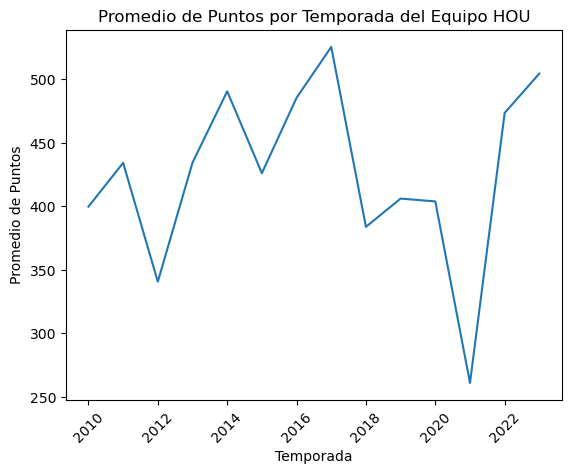

In [7]:
query4 = collection.aggregate([
    { "$match": { "team": "HOU" } },
    { "$group": { "_id": "$season", "avgPoints": { "$avg": "$PTS" } } },
    { "$sort": { "_id": 1 } }
])

df4 = pd.DataFrame(list(query4))

display(df4)
plt.plot(df4['_id'], df4['avgPoints'])
plt.xticks(rotation=45)
plt.ylabel('Promedio de Puntos')
plt.xlabel('Temporada')
plt.title('Promedio de Puntos por Temporada del Equipo HOU')
plt.show()


## Cassandra


Pregunta: ¿Quién es el jugador con más puntos en la temporada 2020 para el equipo de Houston (HOU)?

In [14]:
#SELECT player_name, MAX(PTS) FROM nba_stats WHERE team = 'HOU' AND season = 2020 ALLOW FILTERING;

session = cluster.connect('nba')


query = "SELECT player_name, MAX(PTS) FROM player_stats WHERE team = 'HOU' AND season = 2020 ALLOW FILTERING;"
rows = session.execute(query)


# Creando un DataFrame con los resultados
df = pd.DataFrame(list(rows))
print(df)



#Esta consulta muestra el jugador con el mayor número de puntos en una temporada específica para el equipo de Houston.

      player_name  system_max_pts
0  William Howard            2335


Pregunta: ¿Cuál es el promedio de rebotes totales (TRB) por juego para el equipo de Boston (BOS) en la temporada 2021?

In [16]:
#SELECT AVG(TRB) FROM nba_stats WHERE team = 'BOS' AND season = 2021 ALLOW FILTERING;

query = "SELECT AVG(TRB) FROM nba.player_stats WHERE team = 'BOS' AND season = 2021 ALLOW FILTERING;"
rows = session.execute(query)

df = pd.DataFrame(list(rows))
print(df)

average_trb = df.iloc[0,0]  # Asumiendo que el resultado es la primera fila y columna
print("El promedio de TRB para el equipo 'BOS' en la temporada 2021 es:", average_trb)


#Esta consulta calcula el promedio de rebotes totales por juego para el equipo de Boston en una temporada específica.

   system_avg_trb
0             151
El promedio de TRB para el equipo 'BOS' en la temporada 2021 es: 151


Pregunta: ¿Cuántos juegos ganó el equipo de Toronto (TOR) en la temporada 2019?

In [18]:
#SELECT COUNT(games) FROM nba_stats WHERE team = 'TOR' AND season = 2019 AND games_started > 0 ALLOW FILTERING;

query = "SELECT COUNT(games) FROM nba.player_stats WHERE team = 'TOR' AND season = 2019 AND games_started > 0 ALLOW FILTERING;"
rows = session.execute(query)

df = pd.DataFrame(list(rows))
print(df)

count_games = df.iloc[0,0]  # Asumiendo que el resultado es la primera fila y columna
print(f"El número de juegos para el equipo 'TOR' en la temporada 2019 con games_started > 0 es: {count_games}")
#Esta consulta cuenta el número de juegos en los que los
# jugadores de Toronto iniciaron, lo que puede ser un indicador 
# aproximado de los juegos ganados.

   system_count_games
0                   0
El número de juegos para el equipo 'TOR' en la temporada 2019 con games_started > 0 es: 0


       player_name  season  ast  stl
0     James Harden    2015  565  154
1     Jrue Holiday    2013  625  123
2   T.J. McConnell    2017  534  134
3      Ben Simmons    2019  610  112
4     James Harden    2020  512  125
5      Ben Simmons    2018  661  140
6     Jrue Holiday    2011  531  120
7     James Harden    2017  907  121
8     James Harden    2018  630  126
9      Rajon Rondo    2011  760  153
10    James Harden    2016  612  139
11      Kyle Lowry    2014  586  121
12     Rajon Rondo    2010  794  189
13    James Harden    2019  586  158


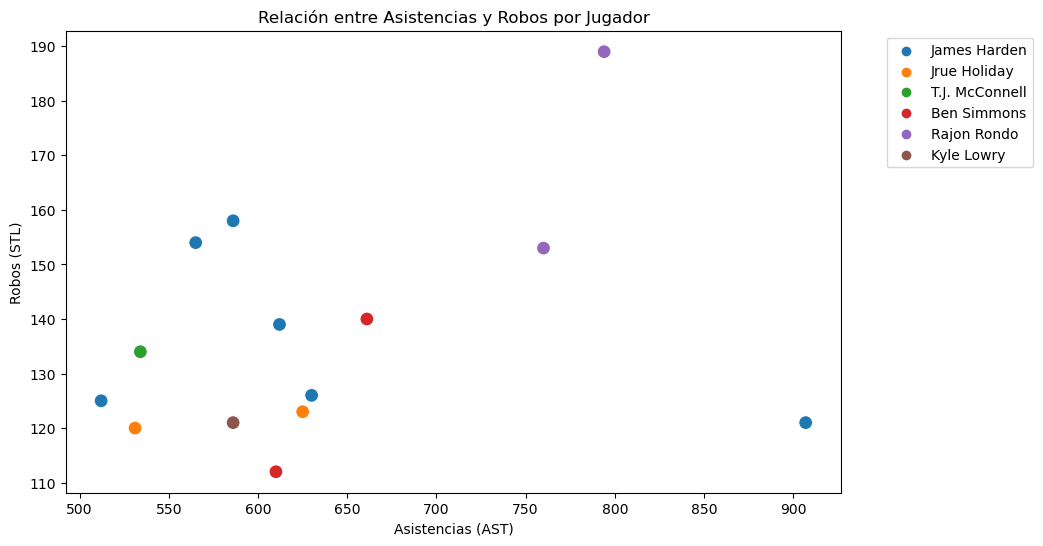

In [39]:
query = """
SELECT player_name, season, AST, STL
FROM player_stats
WHERE AST > 500 AND STL > 100
ALLOW FILTERING;
"""
rows = session.execute(query)
df = pd.DataFrame(list(rows))
print(df)


if not df.empty and 'ast' in df.columns and 'stl' in df.columns:

    # Crear un gráfico de dispersión
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='ast', y='stl', hue='player_name', s=100)

    # Agregar títulos y etiquetas
    plt.title('Relación entre Asistencias y Robos por Jugador')
    plt.xlabel('Asistencias (AST)')
    plt.ylabel('Robos (STL)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Mostrar el gráfico
    plt.show()
else:
    print("El DataFrame está vacío o no contiene las columnas 'ast' y 'stl'.")


           player_name  season team  field_percent  field_attempts
7        Dwight Howard    2016  HOU          0.620             600
20   Amar'e Stoudemire    2011  NYK          0.502            1482
25        Clint Capela    2019  HOU          0.648             732
33      Thaddeus Young    2011  PHI          0.541             847
39        Kyrie Irving    2021  BRK          0.506            1086
..                 ...     ...  ...            ...             ...
359       Tyler Zeller    2015  BOS          0.549             619
361        Ben Simmons    2021  PHI          0.557             583
405          Ömer Aşık    2013  HOU          0.541             614
408  Kenyon Martin Jr.    2023  HOU          0.569             720
414     Andray Blatche    2013  BRK          0.512             676

[68 rows x 5 columns]


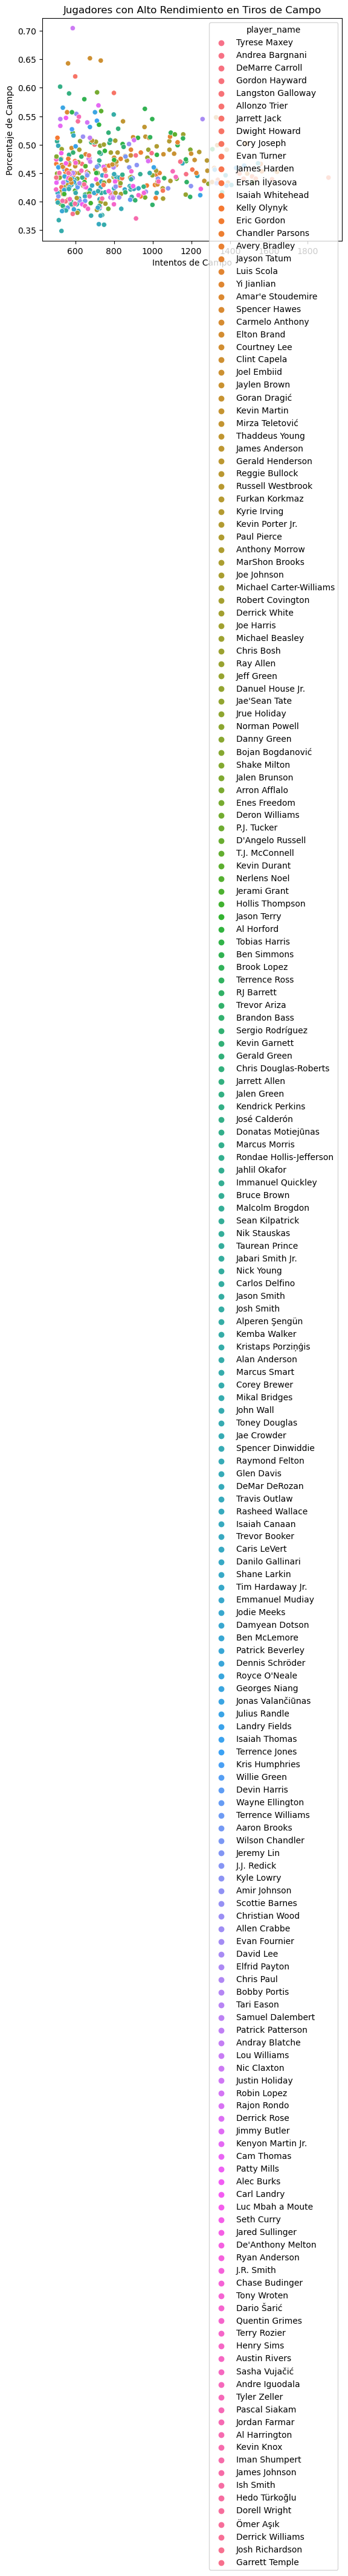

In [33]:
query = """
SELECT player_name, season, team, field_percent, field_attempts
FROM player_stats
WHERE field_attempts > 500
ALLOW FILTERING;
"""
rows = session.execute(query)
df = pd.DataFrame(list(rows))

# Convertir field_percent a número y filtrar
df['field_percent'] = pd.to_numeric(df['field_percent'], errors='coerce')
df_filtered = df[df['field_percent'] >= 0.500]

print(df_filtered)

df['field_percent'] = pd.to_numeric(df['field_percent'], errors='coerce')

# Graficar
sns.scatterplot(data=df, x='field_attempts', y='field_percent', hue='player_name')
plt.title('Jugadores con Alto Rendimiento en Tiros de Campo')
plt.xlabel('Intentos de Campo')
plt.ylabel('Porcentaje de Campo')
plt.show()



          player_name  season team  drb  blk
0       Dwight Howard    2016  HOU  597  113
1        James Harden    2015  HOU  384   60
2        Jayson Tatum    2019  BOS  407   57
3   Amar'e Stoudemire    2011  NYK  438  150
4       Spencer Hawes    2013  PHI  417  113
..                ...     ...  ...  ...  ...
89        Aron Baynes    2018  BOS  304   51
90    Andrea Bargnani    2010  TOR  388  111
91      Kevin Garnett    2013  BOS  455   62
92          Ömer Aşık    2013  HOU  681   87
93       James Harden    2019  HOU  452   58

[94 rows x 5 columns]


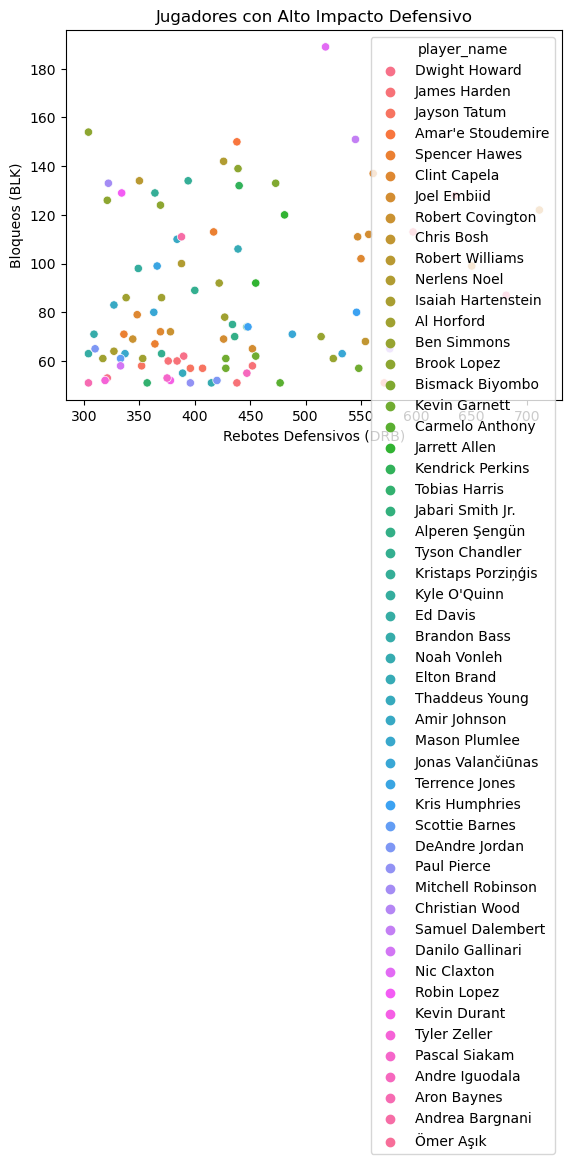

In [40]:
query = """
SELECT player_name, season, team, DRB, BLK
FROM player_stats
WHERE DRB > 300 AND BLK > 50
ALLOW FILTERING;
"""
rows = session.execute(query)
df = pd.DataFrame(list(rows))
print(df)

sns.scatterplot(data=df, x='drb', y='blk', hue='player_name')
plt.title('Jugadores con Alto Impacto Defensivo')
plt.xlabel('Rebotes Defensivos (DRB)')
plt.ylabel('Bloqueos (BLK)')
plt.show()